In [1]:
from Classes.Grid import Grid
from Classes.ScalarCoeffs import ScalarCoeffs
from Classes.BoundaryConditions import BoundaryLocation, DirichletBc, NeumannBc, RobinBc
from Classes.Models import DiffusionModel, SurfaceConvectionModel, FirstOrderTransientModel, SecondOrderTransientModel, CrankNicholsonTransientModel 
from Classes.LinearSolver import solve

import numpy as np
import math
import matplotlib.pyplot as plt
from numpy.linalg import norm
from enum import Enum
from scipy import interpolate

In [2]:
class TransientModel(Enum):
    """Enumeration class defining transient model types"""
    FIRSTORDERIMPLICIT = 1
    SECONDORDERIMPLICIT = 2
    CRANKNICHOLSON = 3

def Solve(grid, dt, nTime, transientModel, T, verbose = False):
    """Function to solve temperature distribution for a specific grid,
    transient model and nTime"""
    
    # Set initial Time
    time = 0.4535
    
    # Set the maximum number of iterations and convergence criterion
    maxIter = 100
    converged = 1e-10

    # Define thermophysical properties
    rho = 1
    cp = 1
    k = 1

    # Define convection parameters
    ho = 1
    To = 0
    
    # Define the coefficients
    coeffs = ScalarCoeffs(grid.ncv)

    # Define boundary conditions
    east_bc = RobinBc(T, grid, ho, To, k, BoundaryLocation.EAST)
    west_bc = NeumannBc(T, grid, 0, BoundaryLocation.WEST)

    # Apply boundary conditions
    west_bc.apply()
    east_bc.apply()

    # Create list to store the solutions at each timestep
    T_solns = [np.copy(T)]

    # Define additional transient model parameters
    Told = np.copy(T)
    Tolder = np.copy(T)
    
    # Select the appropriate transient model
    if transientModel == TransientModel.FIRSTORDERIMPLICIT:
        transient = FirstOrderTransientModel(grid, T, Told, rho, cp, dt)
    elif transientModel == TransientModel.SECONDORDERIMPLICIT:
        transient = SecondOrderTransientModel(grid, T, Told, Tolder, rho, cp, dt)
    elif transientModel == TransientModel.CRANKNICHOLSON:
        transient = CrankNicholsonTransientModel(grid, T, Told, Tolder, rho, cp, dt, k)

    # Define the diffusion model
    diffusion = DiffusionModel(grid, T, k, west_bc, east_bc)

    # Loop through all timesteps
    for tStep in range(nTime):
        # Update the time information
        time += dt

        # Print the timestep information
        if verbose:
            print("Timestep = {}; Time = {}".format(tStep, time))

        # Store the "old" temperature field
        Tolder[:] = Told[:]
        Told[:] = T[:]

        # Iterate until the solution is converged
        for i in range(maxIter):
            
            # Zero the coefficients and add each influence
            coeffs.zero()
            coeffs = transient.add(coeffs)
            coeffs = diffusion.add(coeffs)

            # Compute residual and check for convergence 
            maxResid = norm(coeffs.rP, np.inf)
            avgResid = np.mean(np.absolute(coeffs.rP))
            
            if verbose:
                print("Iteration = {}; Max. Resid. = {}; Avg. Resid. = {}".format(i, maxResid, avgResid))
            if maxResid < converged:
                break

            # Solve the sparse matrix system
            dT = solve(coeffs)

            # Update the solution and boundary conditions
            T[1:-1] += dT
            west_bc.apply()
            east_bc.apply()

        # Store the solution
        T_solns.append(np.copy(T))
        
    return T_solns

In [3]:
def Plot(ncv, nTimes):
    
    # Initialize grid and delta times
    grid = Grid(1, 1, 1, ncv)
    startTime = 0.4535
    endTime = 3.2632
    deltaTimes = [(endTime-startTime)/j for j in nTimes]
    
    # Initialize temperature array
    Ti = 100
    To = 0
    T = 1.1191 * math.exp(-0.8603**2 * 0.4535) * np.cos(0.8603 * grid.xP) * (Ti - To) + To
    TFinal = 1.1191 * math.exp(-0.8603**2 * 3.2632) * np.cos(0.8603 * grid.xP) * (Ti - To) + To
    
    # Store centerline temperature values at time t2 = 3.2632 s
    TErrorsFirstOrderImplicit = []
    TErrorsSecondOrderImplicit = []
    TErrorsCrankNicholson = []
    
    # Store average error values at time t2 = 3.2632 s
    T0FirstOrderImplicit = []
    T0SecondOrderImplicit = []
    T0CrankNicholson = []
    
    # Setup error calculation function
    ErrorFunc = lambda TFinalNumerical, TFinalExact: sum(abs(TFinalNumerical - TFinal)) / (grid.ncv+2)

    # Iterate over different dt values and store centerline temperatur and average error values
    for dt, nTime, in zip(deltaTimes, nTimes):
        
        T_solns1 = Solve(grid, dt, nTime, TransientModel.FIRSTORDERIMPLICIT, np.copy(T))
        T_solns2 = Solve(grid, dt, nTime, TransientModel.SECONDORDERIMPLICIT, np.copy(T))
        T_solns3 = Solve(grid, dt, nTime, TransientModel.CRANKNICHOLSON, np.copy(T))
        
        T0FirstOrderImplicit.append(T_solns1[-1][0])
        T0SecondOrderImplicit.append(T_solns2[-1][0])
        T0CrankNicholson.append(T_solns3[-1][0])
        
        TErrorsFirstOrderImplicit.append(ErrorFunc(T_solns1[-1], TFinal))
        TErrorsSecondOrderImplicit.append(ErrorFunc(T_solns2[-1], TFinal))
        TErrorsCrankNicholson.append(ErrorFunc(T_solns3[-1], TFinal))
    
    # Set up 1x2 subplots
    f, (ax1, ax2) = plt.subplots(1,2)
    f.set_figheight(7)
    f.set_figwidth(15)

    # Plot centerline temperature values at t2 on the first (left) subplot
    ax1.loglog(deltaTimes, T0FirstOrderImplicit, "-o", label="First Order Implicit")
    ax1.loglog(deltaTimes, T0SecondOrderImplicit, "-o", label="Second Order Implicit")
    ax1.loglog(deltaTimes, T0CrankNicholson, "-o", label="Crank-Nicholson")
    ax1.set_xlabel(r"$\Delta t$")
    ax1.set_ylabel("$T_{x=0}$ [C]")
    ax1.set_xticklabels([i for i in deltaTimes])
    ax1.set_xticks(deltaTimes)
    ax1.legend()
    ax1.title.set_text('Figure 1. T(0,$t_2$) Plot')

    # Plot average error values at t2 on the second (right) subplot
    ax2.loglog(deltaTimes, TErrorsFirstOrderImplicit, "-o", label="First Order Implicit")
    ax2.loglog(deltaTimes, TErrorsSecondOrderImplicit, "-o", label="Second Order Implicit")
    ax2.loglog(deltaTimes, TErrorsCrankNicholson, "-o", label="Crank-Nicholson")
    ax2.set_xlabel(r"$\Delta t (log scale)$")
    ax2.set_ylabel("Average Absolute Error (log scale)")
    ax2.set_xticklabels([i for i in deltaTimes])
    ax2.set_xticks(deltaTimes)
    ax2.legend()
    ax2.title.set_text('Figure 2. Average Absolute Error Plot')

    plt.show()
    
    # Output p values
    print("First Order Implicit p = ", round(np.polyfit(np.log(deltaTimes), np.log(TErrorsFirstOrderImplicit), 1)[0], 2))
    print("Second Order Implicit p = ", round(np.polyfit(np.log(deltaTimes), np.log(TErrorsSecondOrderImplicit), 1)[0],2))
    print("Crank-Nicholson p = ", round(np.polyfit(np.log(deltaTimes), np.log(TErrorsCrankNicholson), 1)[0],2))

C:\Users\Sameed\Documents\Masters\MME9701\Python\env\lib\site-packages\ipykernel_launcher.py:54: UserWarning: FixedFormatter should only be used together with FixedLocator
C:\Users\Sameed\Documents\Masters\MME9701\Python\env\lib\site-packages\ipykernel_launcher.py:65: UserWarning: FixedFormatter should only be used together with FixedLocator


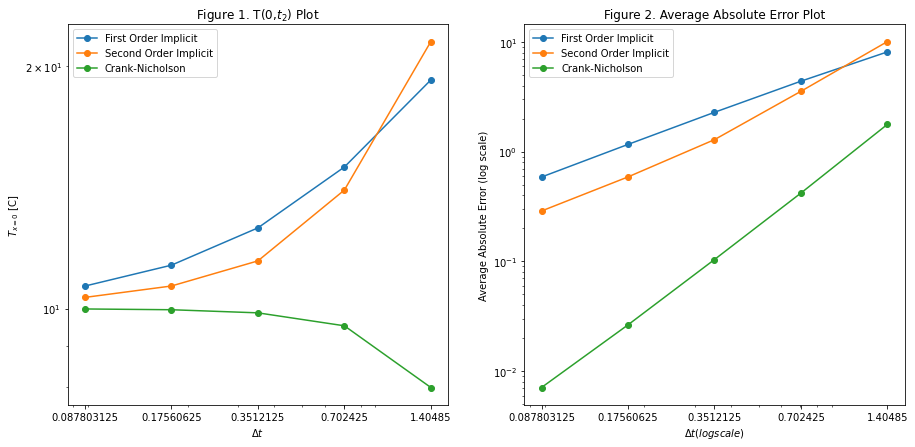

First Order Implicit p =  0.95
Second Order Implicit p =  1.28
Crank-Nicholson p =  1.99


In [4]:
Plot(50, [2,4,8,16,32])

Figure 1 shows centerline temperature at t = $t_2$ plotted against time steps for the three transient models. Based on current formulations, the Crank-Nicholson model is observed to converge to the exact solution the fastest, followed by the second order and first order implicit schemes. This can be more readily seen in figure 2 which plots the average absolute error over the same time steps on a log-log scale. It can be seen that Crank-Nicholson not only minimizes error the fastest (greatest slope) but also converges to the smallest error. This performance is followed by that of second order implicit and finally first order implicit models. 

The order of accuracy of a given model (scheme) is given by the slope of this log-log plot. The Crank-Nicholson, second order implicit and first order implicit models have numerical orders of accuracy of 2, 1.3 and 1 respectively. In the case of Crank-Nicholson and first order implicit schemes, these results match up with their actual orders of accuracy. The second order implicit formulation, however, lacks in approaching its actual order of accuracy of 2.

In [9]:
def GridIndependentPlot(ncvList, nTime):
    
    # Initialize grids
    grids = [Grid(1, 1, 1, ncv) for ncv in ncvList]
    startTime = 0.4535
    endTime = 3.2632
    dt = (endTime-startTime)/nTime
    
    # Setup Initial temperature
    Ti = 100
    To = 0
    
    # Store temperature distributions for the three transient models
    TFirstOrderImplicit = []
    TSecondOrderImplicit = []
    TCrankNicholson = []
    
    # Iterate over the different grids and store temperature distributions
    for grid in grids:
        T = 1.1191 * math.exp(-0.8603**2 * 0.4535) * np.cos(0.8603 * grid.xP) * (Ti - To) + To
        TFirstOrderImplicit.append(Solve(grid, dt, nTime, TransientModel.FIRSTORDERIMPLICIT, np.copy(T))[-1])
        TSecondOrderImplicit.append(Solve(grid, dt, nTime, TransientModel.SECONDORDERIMPLICIT, np.copy(T))[-1])
        TCrankNicholson.append(Solve(grid, dt, nTime, TransientModel.CRANKNICHOLSON, np.copy(T))[-1])

    # Set up 1x2 subplots for first order and second order implicit transient model plots
    f, (ax1, ax2) = plt.subplots(1,2)
    f.set_figheight(5)
    f.set_figwidth(16)
    
    # Plot Temperature distributions
    styles = ["--o", "--+", "--x", "--*", "--^"]
    for i,grid in enumerate(grids):
        ax1.plot(grid.xP, TFirstOrderImplicit[i], styles[i], label="NCV:{}".format(grid.ncv))
        ax2.plot(grid.xP, TSecondOrderImplicit[i], styles[i], label="NCV:{}".format(grid.ncv))
    
    ax1.set_ylabel("T [C]")
    ax1.set_xlabel("x*")
    ax1.legend()
    ax1.title.set_text('Figure 3. Final T Distribution: First Order Implicit')
    
    ax2.legend()
    ax2.title.set_text('Figure 4. Final T Distribution: Second Order Implicit')
    ax2.set_ylabel("T [C]")
    ax2.set_xlabel("x*")
    
    plt.show()
    
    return [TFirstOrderImplicit, TSecondOrderImplicit, TCrankNicholson], [grid.xP for grid in grids]

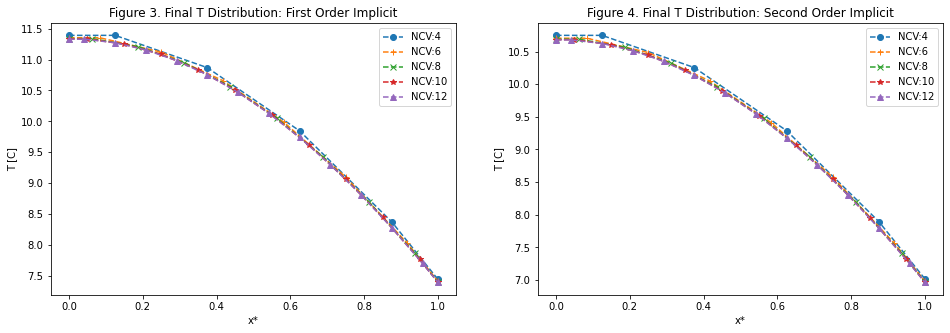

In [10]:
ncvList = [4,6,8,10,12]
nTime = 16
T, x = GridIndependentPlot(ncvList, nTime)

Figure 3 shows temperature distribution at t = $t_2$ for different grids (different number of internal nodes) for the first order implicit model. Figure 4 shows the same plot for the second order implicit model. It can be seen that both formulations follow the same pattern of convergence as the number of internal nodes is increased. The absolute error going from 4 internal nodes to 6 internal nodes is the highest and gradually decreases thereafter. Next, we analyze this absolute error between consecutive grids in more detail.

In [11]:
from scipy import interpolate

def CalculateTotalAbsoluteError(x_all, T_all):
    # Create template x array corresponding to first grid where temperature values for all other grids are to be interpolated at 
    x_template = x_all[0]

    # Create list to store interpolated temperature values for all grids
    y_interpolated_all = []

    # Loop through all grids and calculate temperature values corresponding to x_template locations
    for x,T_sln in zip(x_all,T_all):
        f = interpolate.interp1d(x, T_sln)
        y_new = f(x_template)
        y_interpolated_all.append(y_new)

    # Calculate absolute differences in grid temperature values (abs(Tgrid2-Tgrid1), abs(Tgrid3-Tgrid2), ...)
    absDiff = np.abs(np.diff(y_interpolated_all, axis=0))

    # Calculate total absolute differences between grid temperature values
    totalAbsDiff = np.sum(absDiff, axis=1)

    # Add zero difference corresponding to difference between first grid and itself (template grid)
    totalAbsDiff = [0] + list(totalAbsDiff)
    
    # Output list of total absolute differences
    #print("Total Absolute Differences: {}".format(totalAbsDiff))

    # Plot total absolute grid temperature differences
    #ax.plot(range(0,len(x_all)), totalAbsDiff, '-o')
    
    return totalAbsDiff

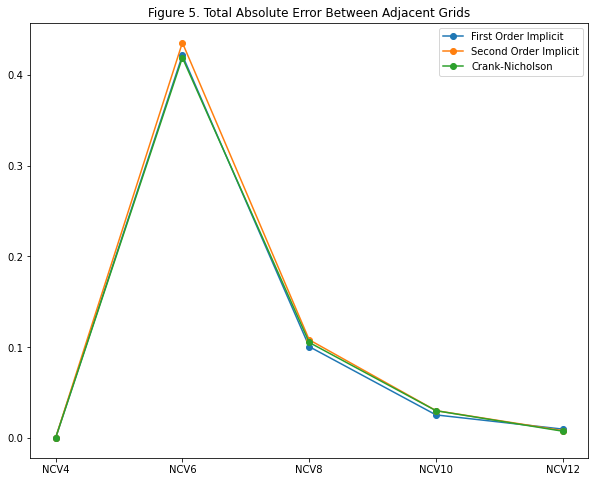

In [12]:
fig, ax = plt.subplots()
fig.set_figwidth(10)
fig.set_figheight(8)

Errors = []
labels = ["First Order Implicit", "Second Order Implicit", "Crank-Nicholson"]
for Ti in T:
    Errors.append(CalculateTotalAbsoluteError(x, Ti))
    
for i,error in enumerate(Errors):
    plt.plot(error, '-o', label = labels[i])

plt.xticks(np.arange(len(error)), np.arange(1, len(error)+1))
ax.set_xticklabels(['NCV{}'.format(i) for i in ncvList])
ax.set_title("Figure 5. Total Absolute Error Between Adjacent Grids")
ax.legend()
plt.show()

Figure 5 shows a plot of absolute errors between consecutive grids. It can be seen that all three transient models follow the same pattern which emphasizes that grid independence is decoupled from time independence. The error going from 10 internal nodes to 12 internal nodes is negligible. Therefore, the **solution become grid independent at 10 internal nodes**.